## Computational Neuroscience

Marijn van Wingerden, Department of Cognitive Science and Artificial Intelligence – Tilburg University Academic Year 2020-2021

In this Jupyter Notebook, you will find the programmatic instructions to complete the project. 

You will analyse a subset of the trials and conditions from the RITA dataset, as introduced by dr. Roncaglia in the second week of class. Your time-resolved analysis, using the FFT and baseline averaging, will be performed across ALL subjects in a group (Monolinguals, Early Learners, Late Learners) in the dataset, and look for oscillatory activity in relation to the onset of the **critical item** in each sentence (the auxilary verb).

You will inspect activity in the following frequency bands:
- Delta (1-4 Hz)
- Theta (4-8 Hz)
- Alpha (8-12 Hz)
- Beta (15-25 Hz)
- low Gamma (30-60 Hz)
- high Gamma (60-100 Hz)
(different cutoffs points can be found in the literature, we are sticking with these for convenience)


## Datafiles - assignment 

Each group will analyze one set of filler sentences (NA: Non-Ambiguous sentences) and a set of experimental sentences (AM: Ambiguous sentences). The conditions in the dataset are split over groups in the following way:

You can download the datafiles from: https://surfdrive.surf.nl/files/index.php/s/JcA9speED020q4p

## Setting up: list your modules to import
For loading/saving puroposes, we will make use of the **os** package.
An example worksheet with instructions on how to use the os package will be provided

In [29]:
%matplotlib notebook

import os
import numpy as np
from pprint import pprint
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.fft as fft

## Data loading
We will need to load the datafiles from all participants and add them all together so that we end up with a matrix that has nChannels x nTime x nParticipants (instead of trials). You can make your work easier by organising the datafiles in such a way that you put the control.npy files in their own subdirectory, and the experimental.npy files as well. 

In order to load the files, we can use the os package.

Adapt the following so that it works on your machine:

In [30]:
# Get current working directory
wd = os.getcwd()
print(wd) 

C:\Users\Admin\Desktop\Tilburg University\Year 2\Semester 2\Cognitive Neuroscience\Group Project


In [31]:
path_control =  wd + '/Project_Data_Files/' + 'group_15/'
path_experimental = wd + '/Project_Data_Files/' + 'group_15/'
path_base = wd + '/Project_Data_Files/' + 'group_15/'
files = os.listdir(path_base)
control_files = list()
experimental_files = list()

for f in files:
	# check the files that end with specific extention 
    if f.rfind("part_10") > -1:
        continue
    elif f.endswith("control.npy"):
        control_files.append(f)
    elif f.endswith("experimental.npy"):
        experimental_files.append(f)
            

# check that the length of your files list matches the provided datafiles, and contains only .npy datafiles

control_files.sort()
pprint(control_files)
print(len(control_files))
experimental_files.sort()
pprint(experimental_files)
print(len(experimental_files))

['group_15_part_01_control.npy',
 'group_15_part_02_control.npy',
 'group_15_part_03_control.npy',
 'group_15_part_04_control.npy',
 'group_15_part_05_control.npy',
 'group_15_part_06_control.npy',
 'group_15_part_07_control.npy',
 'group_15_part_08_control.npy',
 'group_15_part_09_control.npy',
 'group_15_part_11_control.npy',
 'group_15_part_12_control.npy',
 'group_15_part_13_control.npy',
 'group_15_part_14_control.npy',
 'group_15_part_15_control.npy',
 'group_15_part_16_control.npy',
 'group_15_part_17_control.npy',
 'group_15_part_18_control.npy',
 'group_15_part_19_control.npy',
 'group_15_part_20_control.npy',
 'group_15_part_21_control.npy',
 'group_15_part_22_control.npy']
21
['group_15_part_01_experimental.npy',
 'group_15_part_02_experimental.npy',
 'group_15_part_03_experimental.npy',
 'group_15_part_04_experimental.npy',
 'group_15_part_05_experimental.npy',
 'group_15_part_06_experimental.npy',
 'group_15_part_07_experimental.npy',
 'group_15_part_08_experimental.npy',


## Combining data and matrix pre-allocation
next, you will need to load these files one by one and extract the data for this participant. 
The data in the NumPy arrays are stored as Trials x Channels x Time. To aggregate across participants, you will thus need to add a 4th dimension to store the data.

To be able to adequately pre-allocate the data from the different subjects, we will load one trial subject manually to have a look at the shape/dimensionality of the data:

In [32]:
EEG = np.load(os.path.join(path_control,control_files[0]))
              
# control_files is a list of strings, so indexing its first element returns a string
# in this case, we are loading the first entry of control_files, i.e. participant 1

# verify that the number of trials equals 22, 
# verify that the number of channels equals 64 or 65 
# and verify that there are 751 samples per trace

print("Number of trials = ", EEG.shape[0])
print("Number of channels = ", EEG.shape[1])
print("Number of timepoints = ", EEG.shape[2])

Number of trials =  22
Number of channels =  64
Number of timepoints =  751


## Q1 - setting up the data structure and loading data from all participants

The EEG data is currently stored as a 3-dimensional NumPy array. But to run our time-frequency analysis, we need some more information like the sampling rate and the time axis that corresponds to the stimulus-locked analysis window. In order to set up (=pre-allocate) a matrix that will hold all traces for all participants, we need to know the sizes of the dimensions of this 4-dimensional matrix, and fill up this matrix by looping over participants:

In [33]:
# There are 64 or 65 channels in the dataset. Only channels up to channel 59 are EEG channels
# the remaining channels are EMG and EOG channels that we will ignore in this analysis
# subset your EEG array so that only the EEG channels remain

EEG = EEG[:,:59,:]
print(EEG.shape)

# Define nTrials, nChans (=channels), nSamples and nParts (=participants). Then, pre-allocate a matrix
# filled with zeros and with size nTrials x nChans x nSamples x nParticipants, one each for the control
# and experimental data. Name them comb_data_control and comb_data_experimental
nTrials = EEG.shape[0]
nChans = EEG.shape[1]
nSamples = EEG.shape[2]
nParts = len(control_files)
comb_data_control = np.zeros((nTrials , nChans, nSamples , nParts))
comb_data_experimental = np.zeros((nTrials , nChans, nSamples , nParts))

# next, we need to loop over all participant datafiles and add them to the appropriate slice in your 4-D arrays
# For this, you need to use specific array indexing to indicate where in comb_data_(control/experimental)
# each participant's data needs to go. You can and should reuse the data-reading code above.

# loop over participants, and wihtin each iteration of the loop, load the
# next datafile and fill comb_data_(control/experimental) with the EEG traces (nTrials x nChans x nSamples)
# check the shape of the matrices after filling them

for iPart in range(len(control_files)):
    comb_data_control[:,:,:,iPart] = np.load(os.path.join(path_control,control_files[iPart]))[:,:59,:]
    comb_data_experimental[:,:,:,iPart] = np.load(os.path.join(path_control,experimental_files[iPart]))[:,:59,:]
print(comb_data_control.shape)
print(comb_data_experimental.shape)

(22, 59, 751)
(22, 59, 751, 21)
(22, 59, 751, 21)


## Q2 - explore the data

Let's explore this newly combined dataset a little bit. This collection of EEG traces in your dataset has been taken with a [-0.5s, 1s] window around the relevant event. What's more, each trace has been averaged to its baseline period, so that the mean amplitude should be 0 (with some rounding error). 

To verify, first, determine the mean for the time period of -0.5 to 0 seconds. Given that the srate = 500 Hz, the baseline period corresponds to the first 250 samples. We will work with only the control dataset (comb_data_control) in this exercise.
- subset your combined data to only the first 250 samples
- select a random participant and subset the data further to only this participant
- select a random EEG channel and subset the data further to only this channel

This should leave you with a nTrials x 250 (samples) matrix. Create a similar evoked matrix with the remainder of the samples. With these matrices, in a 1x3 subplot 
- plot the traces for all trials in the **baseline** matrix (use transpose if necessary).
    - the plot should have 250 samples on the x-axis, and nTrial number of lines
- calculate the mean for each trace (i.e., across the samples in a trace):
    - once for the baseline period
    - once for the remainder of the trial
- plot these values (N of these values should be nTrials, check this) in a histogram, each in their own subplot


(22, 59, 250, 21)
(22, 59, 250)
(22, 250)
(22, 59, 501, 21)
(22, 59, 501)
(22, 501)
(22,)
(22,)


<IPython.core.display.Javascript object>


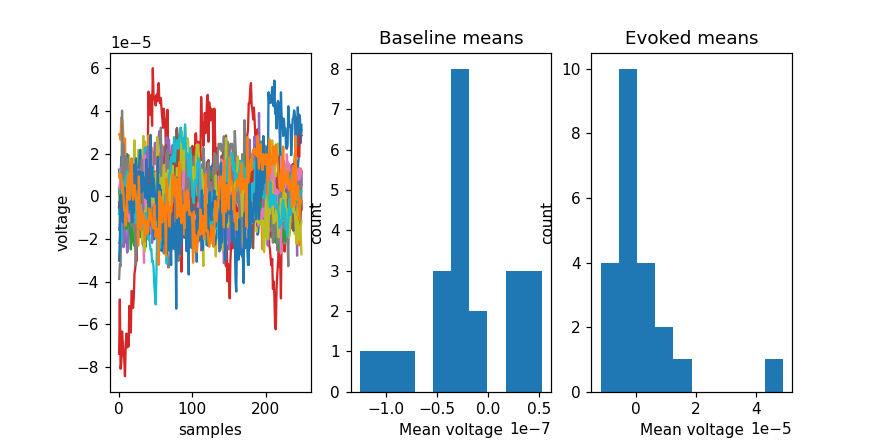

In [34]:
subset_baseline = comb_data_control[:,:,:250,:]
print(subset_baseline.shape) # trials x channels x timepoints x participants
subset_participant_baseline = subset_baseline[:,:,:,1]
print(subset_participant_baseline.shape) # trials x channels x timepoints
subset_channel_baseline = subset_participant_baseline[:,20,:]
print(subset_channel_baseline.shape) # trials x timepoints

subset_evoked = comb_data_control[:,:,250:,:]
print(subset_evoked.shape) # trials x channels x timepoints x participants
subset_participant_evoked = subset_evoked[:,:,:,1]
print(subset_participant_evoked.shape) # trials x channels x timepoints
subset_channel_evoked = subset_participant_evoked[:,20,:]
print(subset_channel_evoked.shape) # trials x timepoints

baseline_mean = np.mean(subset_channel_baseline, axis = 1) # take mean across samples
print(baseline_mean.shape)
evoked_mean = np.mean(subset_channel_evoked, axis = 1) # take mean across samples
print(evoked_mean.shape)

# now plot these traces and two histograms using the subplot given
fig_Q2A, ax = plt.subplots(figsize=(8,4), nrows=1, ncols=3) # 1x3 graph

# plot the traces in ax[0]
ax[0].plot(np.transpose(subset_channel_baseline))
ax[0].set_xlabel("samples")
ax[0].set_ylabel("voltage")
plt.title("EEG traces in baseline period")

# plot the baseline mean in ax[1] with this code
ax[1].hist(baseline_mean)
plt.axes(ax[1])
plt.title('Baseline means')
ax[1].set_xlabel('Mean voltage')
ax[1].set_ylabel('count')

# plot the evoked mean in ax[2] with this code
ax[2].hist(evoked_mean)
plt.axes(ax[2])
plt.title('Evoked means')
ax[2].set_xlabel('Mean voltage')
ax[2].set_ylabel('count')
plt.show()

Looking at theses histograms, you should see that the distribution of evoked mean values can vary: while EEG recordings are referenced to a common ground, and usualy then re-referenced to the global average, we are dealing here with specific cutouts of EEG traces around specific events in the dataset. The data has been normalised to the baseline window for each trial, but the mean of the evoked part is not controlled. In addition, there might be differences in the size of the amplitudes between channels and between participants due to differences in conductivity.

Illustrate that this global averaging does not guarantee equal variance. Reuse the baseline and evoked subsets:
- Compute, instead of the mean across samples, the standard deviation (numpy.std or variants)
- calculate the standard deviation for each trace:
    - once for the baseline period
    - once for the remainder of the trial
- Adapt the plotting code for Q2A and plot these distributions of standard deviations in figure Q2B.

(22,)
(22,)


<IPython.core.display.Javascript object>


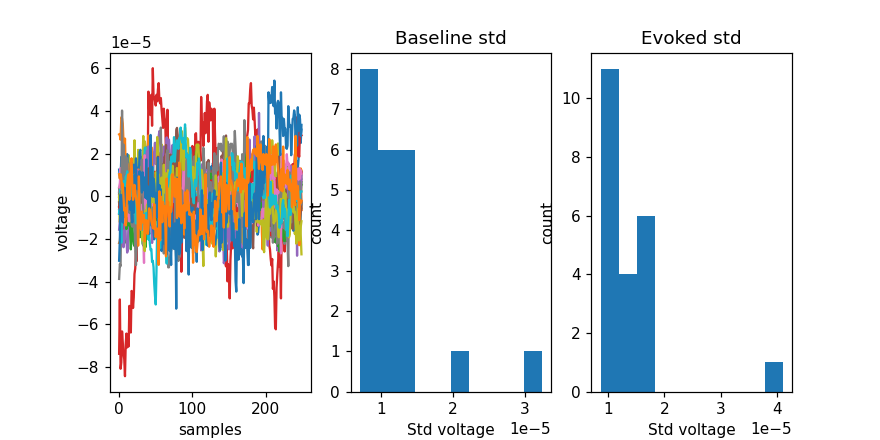

In [35]:
baseline_std = np.std(subset_channel_baseline, axis = 1) # take std across samples
print(baseline_std.shape)
evoked_std = np.std(subset_channel_evoked, axis = 1) # take std across samples
print(evoked_std.shape)

fig_Q2B, ax = plt.subplots(figsize=(8,4), nrows=1, ncols=3) # don't forget proper plot annotation

# plot the traces in ax[0]
ax[0].plot(np.transpose(subset_channel_baseline))
ax[0].set_xlabel("samples")
ax[0].set_ylabel("voltage")
plt.title("EEG traces in baseline period")

# plot the baseline mean in ax[1] with this code
ax[1].hist(baseline_std)
plt.axes(ax[1])
plt.title('Baseline std')
ax[1].set_xlabel('Std voltage')
ax[1].set_ylabel('count')

# plot the evoked mean in ax[2] with this code
ax[2].hist(evoked_std)
plt.axes(ax[2])
plt.title('Evoked std')
ax[2].set_xlabel('Std voltage')
ax[2].set_ylabel('count')
plt.show()



## Q3 - normalizing the data

So, if there are large differences in mean and/or standard deviation between channels or participants, we can implement some standard scaling. First, let think about why this "standard scaling" (substracting the mean, dividing by std) is important? You will be combining data from different participants for these exercises. They have been possibly recorded at different days, with different gels or electrodes, and thus with different conductivity between participants. We will assume that the recording across trials within one participant remains stable. So, in order to compare and average the recordings from different participants "fairly", we want them to be on more or less the same scale.

We can thus attempt to normalize the signal per participant, by dividing all data per participant by its standard deviation. Let's show the extent of the problem by plotting the participants with the lowest and highest std side by side. Re-create your matrix of std values for the evoked period, but:
- do not subset one participant, but retain all participants (still only selecting 1 channel)
- calculate the standard deviation for each trace (across the samples dimension)
- average the std values for each trace over trials, save in part_std 
    - you will retain one value per participant, check this
- use np.argmax (and variants) to create two indexes, min_std and max_std that point to the participants with the lowest and highest standard deviations
- calculate and plot the signal average over trials for these two participants, using different line colors and proper line labeling. 
    - Plot them in the first subplot of a 1x2 subplot
- Observe the scaling difference




(22, 501, 21)
(22, 21)
(21,)
Participants with min_std:  11
Participants with max_std:  4


<IPython.core.display.Javascript object>


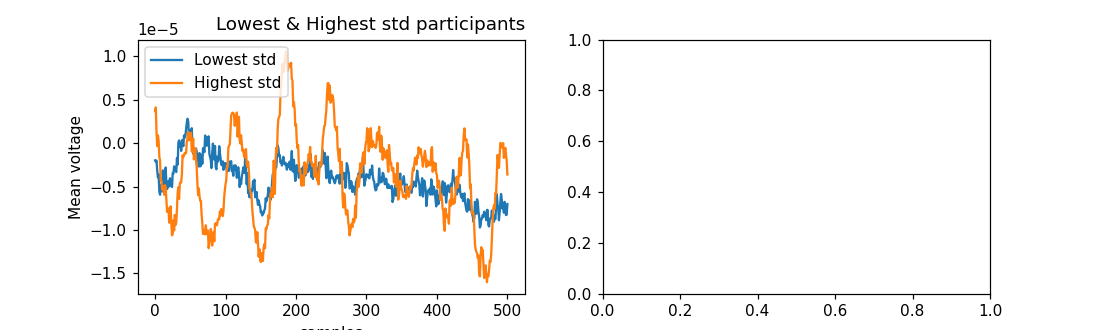

In [36]:
selected_channel = subset_evoked[:,20,:,:]
print(selected_channel.shape)
part_std_all = np.std(selected_channel, axis=1) # we take the std across the second dimension (samples)
print(part_std_all.shape)

part_std = np.mean(part_std_all, axis = 0) # from these, we average across trials
print(part_std.shape)

min_std = np.argmin(part_std,axis=0)
max_std = np.argmax(part_std,axis=0)
print("Participants with min_std: ", min_std)
print("Participants with max_std: ", max_std)

fig_Q3, ax = plt.subplots(figsize=(10,3), nrows = 1, ncols = 2) # don't forget proper plot annotation
ax[0].plot(np.mean(selected_channel[:,:,min_std], axis = 0), label = "Lowest std")
ax[0].plot(np.mean(selected_channel[:,:,max_std], axis = 0), label = "Highest std")
ax[0].legend(loc = 'upper left')
plt.axes(ax[0])
plt.title('Lowest & Highest std participants', loc = 'right')
ax[0].set_xlabel('samples')
ax[0].set_ylabel('Mean voltage')
plt.show()

Next, we want to use the standard deviation for these participants to normalize (i.e. divide) the data by this value. 
- using the selected channel matrix for these two participants as calculated above
    - this should be a trials x timepoints matrix, per participant
    - store as low_std_participant and high_std_participant
- extract the standard deviation for these participant as calculated above
- Normalize both sets traces (per participant) by the participant std
    - save as low_std_norm and high_std_norm
- In the second subplot, plot the **normalized** average signal over trials for these same two participants, using different line colors and proper line labeling. You can replot the figure if you want.
    - Plot them in the second subplot of fig Q3
    - The data should now be more or less on the same scale

(22, 501)
(22, 501)


<IPython.core.display.Javascript object>


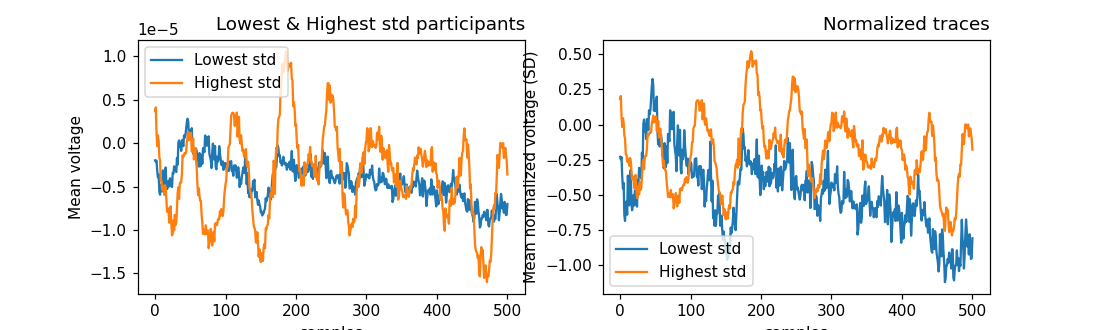

In [37]:
low_std_part = selected_channel[:,:,min_std] # select data from participant with lowest std
low_std_norm = low_std_part / part_std[min_std] # divide by the average std for this participant
print(low_std_norm.shape) # trials x timepoints

high_std_part = selected_channel[:,:,max_std] # select data from participant with highest std
high_std_norm = high_std_part / part_std[max_std] # divide by the average std for this participant
print(high_std_norm.shape) # trials x timepoints

fig_Q3, ax = plt.subplots(figsize=(10,3), nrows = 1, ncols = 2) # don't forget proper plot annotation
ax[0].plot(np.mean(selected_channel[:,:,min_std], axis = 0), label = "Lowest std")
ax[0].plot(np.mean(selected_channel[:,:,max_std], axis = 0), label = "Highest std")
ax[0].legend(loc = 'upper left')
plt.axes(ax[0])
plt.title('Lowest & Highest std participants', loc = 'right')
ax[0].set_xlabel('samples')
ax[0].set_ylabel('Mean voltage')

ax[1].plot(np.mean(low_std_norm, axis = 0), label = "Lowest std")
ax[1].plot(np.mean(high_std_norm, axis = 0), label = "Highest std")
ax[1].legend(loc = 'lower left')
plt.axes(ax[1])
plt.title('Normalized traces', loc = 'right')
ax[1].set_xlabel('samples')
ax[1].set_ylabel('Mean normalized voltage (SD)')

plt.show()


We now have to apply this normalization across all channels. The fairest way is to calculate the grand standard deviation per participant (over all their channels, so the relative scaling between channels remains intact). This will normalize the range of the signal within one participant, so that they will be comparable between participants. We will have to do this both for the control and the experimental dataset.

In order to do this: 
- first preallocate two normalized matrices with the same size as comb_data_(control/experimental), called comb_data_norm_(control/experimental).
- Next, create a loop to go over Participants, and inside the loop:
    - select the data for the current participant (trials x channels x timepoints)
        - separately for the control and experimental datasets.
    - calculate the grand standard deviation per participant 
        - also separately for the control and experimental datasets
    - normalization all values by this grand standard deviation
        - Examine the numpy.std documentation to get a single std value across a 3D matrix
    - save the normalized data per participant in the pre-allocatede normalized matrix 
        - separately for control/experimental datasets


In [38]:
comb_data_norm_control = np.zeros(comb_data_control.shape)
comb_data_norm_experimental = np.zeros(comb_data_experimental.shape)

for iPart in range(len(control_files)):
    # control trials
    curr_dat = comb_data_control[:,:,:,iPart]
    curr_std = np.std(curr_dat)
    comb_data_norm_control[:,:,:,iPart] = comb_data_control[:,:,:,iPart]/curr_std # element-wise division
    # experimental trials
    curr_dat = comb_data_experimental[:,:,:,iPart]
    curr_std = np.std(curr_dat)
    comb_data_norm_experimental[:,:,:,iPart] = comb_data_experimental[:,:,:,iPart]/curr_std # element-wise division
    print("processing participant: ", iPart+1, "of ", len(control_files))
    


processing participant:  1 of  21
processing participant:  2 of  21
processing participant:  3 of  21
processing participant:  4 of  21
processing participant:  5 of  21
processing participant:  6 of  21
processing participant:  7 of  21
processing participant:  8 of  21
processing participant:  9 of  21
processing participant:  10 of  21
processing participant:  11 of  21
processing participant:  12 of  21
processing participant:  13 of  21
processing participant:  14 of  21
processing participant:  15 of  21
processing participant:  16 of  21
processing participant:  17 of  21
processing participant:  18 of  21
processing participant:  19 of  21
processing participant:  20 of  21
processing participant:  21 of  21


Finally, we will be plotting the raw and normalised datasets side by side to observe the differences. Before you starts, make sure you have two 4-dimensional matrices, one for the control data and one for the experimental data. Both should contain the full number of samples (e.g., baseline and evoked period). 

Create a 1x2 subplot, with on the left the raw data and on the right the normalised data
- re-use part of the code in Q2 to make a subset of the baseline data
- from this subset, select a random channel
- for both subsetted matrices, calculate the average signal over trials 
    - this should result in a nTimepoints x nParticipants 2D matrix
    - store as mean_baseline_raw and mean_baseline_norm
- Then, plot this average signal over time (as in Fig Q2A) in a 1x2 subplot
    - for the raw dataset in panel 0
    - for the normalised dataset in panel 1
- Save this figure as Figure1

(22, 59, 250, 21)
(250, 21)
(22, 59, 250, 21)
(250, 21)


<IPython.core.display.Javascript object>


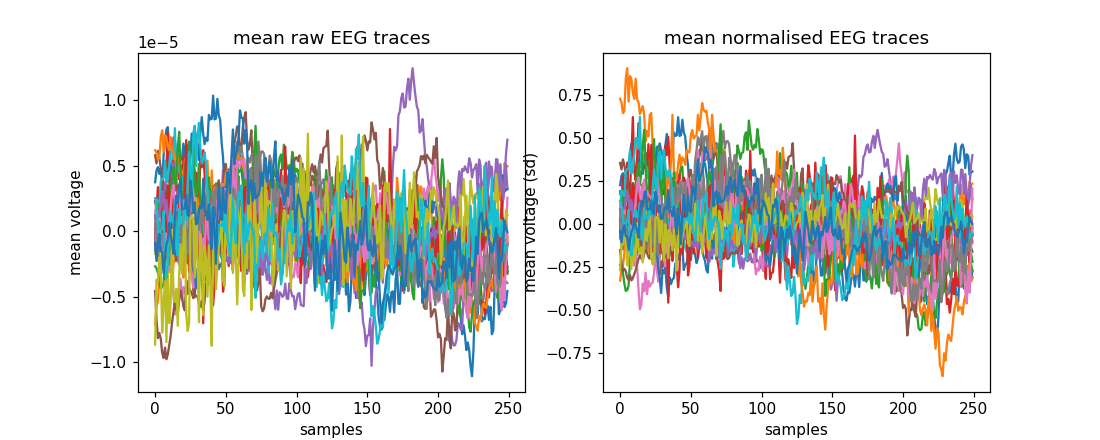

In [39]:
# non-normalised data
subset_baseline_raw = comb_data_control[:,:,:250,:]
print(subset_baseline_raw.shape) # trials x channels x timepoints x participants
subset_channel_baseline_raw = subset_baseline_raw[:,20,:,:]
mean_baseline_raw = np.mean(subset_channel_baseline_raw, axis = 0) # across trials
print(mean_baseline_raw.shape) # timepoints x participants

# normalised data
subset_baseline_norm = comb_data_norm_control[:,:,:250,:]
print(subset_baseline_norm.shape) # trials x channels x timepoints x participants
subset_channel_baseline_norm = subset_baseline_norm[:,20,:,:]
mean_baseline_norm = np.mean(subset_channel_baseline_norm, axis = 0) # across trials
print(mean_baseline_norm.shape) # timepoints x participants

# now plot the raw average traces and normalised average traces
fig_Q3C, ax = plt.subplots(figsize=(10,4), nrows=1, ncols=2) # 1x2 graph

# plot the mean raw traces in ax[0]
ax[0].plot(mean_baseline_raw)
ax[0].set_xlabel("samples")
ax[0].set_ylabel("mean voltage")
plt.axes(ax[0])
plt.title("mean raw EEG traces")

# plot the mean normalised traces in ax[1]
ax[1].plot(mean_baseline_norm)
plt.axes(ax[1])
plt.title("mean normalised EEG traces")
ax[1].set_xlabel('samples')
ax[1].set_ylabel('mean voltage (sd)')
plt.show()

# save Figure Q3C as your Figure 1 for your report
Figure1 = fig_Q3C

You should see that the scaling **within** a participant (line of across-trial average signal) is not really affected, but that potential outliers **between** participants have been brought into the same scale range. 

We are now done with pre-processing of the data and ready to commence the spectral analysis

## Q4 - set up the data structure for Time Frequency Analysis

Now that we have explored and normalized our data, we can proceed with the Time-Frequency Analysis. 

We will need some basic information about the sampling rate and thus the frequency resolution. In addition, we need to define our time axis. You can refer to the earlier notebooks for information on how to do this. The EEG data was sampled at 500 Hz, the first sample was taken at t = -0.5s before the critical time, and the last sample was taken at t = +1.0s after the critical item

- Define the sampling rate (save as srate)
- Define the Nyquist frequency (save as nyquist_freq)
- Define the time step and time axis (save as sample_step and time)


In [40]:
srate = 500

nyquist_freq = srate/2
sample_step = 1/srate;

time = np.arange(start = -0.5, stop = 1, step = sample_step) # in seconds
print("shape of the time axis:",time.shape)

comb_data_norm_experimental.shape

shape of the time axis: (750,)


(22, 59, 751, 21)

## Q5 - preallocating the TFR 5D array

Before we can preallocate our TFR matrix with a time-resolved frequency decomposition (per trial, channel, participants, and per analysis window), we need to figure out how many analysis windows should be in the final array, based on the window length, the overlap and the number of samples in each EEG trace in the dataset. We also need to know how many fourier coefficients we need to store per analysis window.

For the Frequency decomposition to have an optimal temporal resolution, we need to choose an analysis window length that is as short as possible, while still allowing a frequency resolution of 2Hz with the current sampling rate. Notebook 7 explained the relationship between the number of samples and the frequency resolution.

- Define the number of samples that will yield a 2Hz frequency resolution with the current sampling rate
- Calculate spect_freqs as this index of frequencies that can be tested with a 2Hz frequency resolution
- Define nFreq as the number of frequencies that will be analysed

Next, now that we know the size of our analysis window, we can define the timestep between adjacent windows. Remember that we want adjacent analysis windows to overlap, so the move across the time axis is always with a percentage of the length of the analysis window. Our first analysis window start at time index 0 (the first sample). The last window starts at some point on the time axis so that in ends exactly at the second-to-last sample. 

- Set window_step to 4% of the length of the analysis window to allow sufficient overlap between adjacent analysis windows.
- Define nWindows as the number of analysis windows you will be able to fit in the time axis, considering the timestep between adjacent windows.
- create a vector called window_starts that has the starting sample (not time!) of each analysis window. 
    - check your work: as the windows shift by 4% of the window length, the 26th window should start exactly 1 window length after the 1st.

Now, we can pre-allocate our final array to hold the Fourier Spectrum for each window analysed. 
- Pre-allocate a zeros-filled TFR matrix with 5 dimensions: 
    - nTrials x nChans x nWindows x nFreq x nParticipants
    - store as TFR_5D_(control/experimental)
    - add np.nan to the entire matrix. This will fill all positions with NaN


In [41]:
N_window_samples = int(nyquist_freq) 

N = len(time)
spect_freqs = fft.rfftfreq(N, sample_step)
nFreq = fft.rfftfreq(int(N_window_samples), 1/srate)

signal=subset_evoked
total_samples = len(signal) 

window_step = N_window_samples/4
last_window_start = total_samples - N_window_samples 
window_starts = np.arange(start = 0, stop = -last_window_start+1, step = window_step) 
nWindows = len(window_starts)


TFR_5D_control = np.zeros((nTrials, nChans, nWindows, len(nFreq), nParts))
TFR_5D_exp =  np.zeros((nTrials, nChans, nWindows, len(nFreq), nParts))

TFR_5D_control= np.where(TFR_5D_control==0, "NaN", TFR_5D_control) 
TFR_5D_exp= np.where(TFR_5D_exp==0, "NaN", TFR_5D_exp)

print(TFR_5D_control.shape)

#print(TFR_5D_control)

(22, 59, 4, 126, 21)
[[[[['NaN' 'NaN' 'NaN' ... 'NaN' 'NaN' 'NaN']
    ['NaN' 'NaN' 'NaN' ... 'NaN' 'NaN' 'NaN']
    ['NaN' 'NaN' 'NaN' ... 'NaN' 'NaN' 'NaN']
    ...
    ['NaN' 'NaN' 'NaN' ... 'NaN' 'NaN' 'NaN']
    ['NaN' 'NaN' 'NaN' ... 'NaN' 'NaN' 'NaN']
    ['NaN' 'NaN' 'NaN' ... 'NaN' 'NaN' 'NaN']]

   [['NaN' 'NaN' 'NaN' ... 'NaN' 'NaN' 'NaN']
    ['NaN' 'NaN' 'NaN' ... 'NaN' 'NaN' 'NaN']
    ['NaN' 'NaN' 'NaN' ... 'NaN' 'NaN' 'NaN']
    ...
    ['NaN' 'NaN' 'NaN' ... 'NaN' 'NaN' 'NaN']
    ['NaN' 'NaN' 'NaN' ... 'NaN' 'NaN' 'NaN']
    ['NaN' 'NaN' 'NaN' ... 'NaN' 'NaN' 'NaN']]

   [['NaN' 'NaN' 'NaN' ... 'NaN' 'NaN' 'NaN']
    ['NaN' 'NaN' 'NaN' ... 'NaN' 'NaN' 'NaN']
    ['NaN' 'NaN' 'NaN' ... 'NaN' 'NaN' 'NaN']
    ...
    ['NaN' 'NaN' 'NaN' ... 'NaN' 'NaN' 'NaN']
    ['NaN' 'NaN' 'NaN' ... 'NaN' 'NaN' 'NaN']
    ['NaN' 'NaN' 'NaN' ... 'NaN' 'NaN' 'NaN']]

   [['NaN' 'NaN' 'NaN' ... 'NaN' 'NaN' 'NaN']
    ['NaN' 'NaN' 'NaN' ... 'NaN' 'NaN' 'NaN']
    ['NaN' 'NaN' 'NaN' ... 'N

## Q6 - performing a time-resolved frequency analysis

Now that we have the TFR_5D array pre-allocated, we can start to fill this 5D TFR matrix in a quadruple loop. Perform the following steps for your control and experimental TFR_5D arrays:

- Loop over nTrials, nChans and nParticipants. 
- Inside this nested loop, extract the current full EEG trace as curr_signal from comb_data_norm

### important: check if signal is present
For some participants and some trials, the signal you want to extract is actually not present. Check if the current trace is not equal to all zeros (implement a check to see if there is at least one sample that is not zero).
If the current trial **is** all zeros, skip the FFT step for this trial. The powerspectrum should remain NaN for this trial (and all windows in it)

### if there is a signal present

This is the signal we will analyse in consecutive windows inside the fourth loop. 

- Loop over nWindows
- Define curr_start and curr_stop as the sample indices for the current window
- Extract the data from the current window as curr_window
    - check the length: is it indeed as long as N?

Finally, still inside this third nested loop, adapt and perform the FFT analysis from the examples shown in the notebooks. 
- run the FFT
- store the powerspectrum with the correct transformation from the Fourier Coefficients as tmp_ps

This gives you a tmp_ps variable (the current power spectrum) with size 1 x nFreq. Save this powerspectrum in its appropriate place in the TFR_5D matrix.


In [ ]:
##
## your code here
##

Great job! You have now constructed the full time-resolved powerspectrum, across participants, trials and channels for your datasets! In the next part, we will explore these powerspectra and apply one more normalization step before making those nice time-resolved powerspectra or TFRs that go on the fridge.

## Q7 - Extracting the averaged baseline powerspectrum

In this step, you will extract the baseline powerspectrum. In order to do this, you must select the baseline period as the set of one or more of those windows that start from -0.5s and run up to the window that ends at 0s (stimulus presentation), and average the fourier spectra across these windows (e.g. in the time domain). By doing this, we reduce the time-resolved powerspectrum for the baseline period to a single (average) baseline powerspectrum. We retain the dimensions trial, channel and participant, but just collapse (=average) over time. This means your baseline powerspectrum is defined as: nTrials x nChans x nFreq x nPart

- Set base_window_start to 0, as we start from the first window. 
- Using code, set base_window_end as the window that ends just before or at t=0s in the time domain

- Extract the set of windows base_window_start:base_window_end (end-inclusive) from the TFR_5D arrays
- Average across the time dimension if needed
- Store the resulting arrays as TFR_base_(control/experimental)
    - this should yield a 4D-matrix  with size nTrials x nChans x nFreq x nParticipants)
    - check the shapes

In [ ]:
base_window_start = ...
base_window_end = ...

TFR_control_base = ...
TFR_exp_base = ...

## Q8 - visualize the baseline powerspecrtum

To visualizing the average baseline powerspectrum, you will start with a single channel and single participant, and plot the powerspectrum for all trials. Let's take channel Fz as an example. Here is the list of channels (run it from the next code cell).

- construct an index variable "Fz_idx" that holds the index number for the "Fz" channel
- subset TFR_control_base to extract the nTrial x nFreq x nParticipants array for channel Fz. Save as Fz_ps
- select a random participant, subset to retain the nTrial x nFreq powerspectrum array for this person in this channel


In [ ]:
ch_names = ['Fpz', 'Fp1', 'Fp2', 'AFz', 'AF3', 'AF4', 'AF7', 'AF8', 'Fz', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8','FCz', 'FC1', 'FC2', 'FC3', 'FC4', 'FC5', 'FC6', 'FT7', 'FT8', 'Cz', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'T7', 'T8', 'A1', 'A2', 'CPz', 'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', 'TP7', 'TP8', 'Pz', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'POz', 'PO3', 'PO4', 'PO7']

Fz_idx = ...
Fz_ps = ...
Fz_ps_rand = ...



Next, you will plot the baseline powerspectrum 

- Create a 1x2 subplot called fig_Q8A, with on the left the baseline power spectrum for each trials as a separate line
- On the right, plot the average baseline power spectrum for this participant and all participants:
    - calculate the average (use nanmean!) over trials per participant, for all participants. Save as Fz_ps_av
    - plot the averaged baseline power spectra (over trials) for each participant, in grey
    - plot the average baseline power spectrum for your participant againg in color
    - limit the frequency axis for both plots to 100Hz
    - include a legend label that highlights which participant is in red
    - add proper plot annotations

In [ ]:
fig_Q8A, ax = plt.subplots(figsize=(10,4), nrows=1, ncols=2) # 1x2 graph

Fz_ps_av = ...


As you can see from fig Q8A, there are still substantial differences in the overall powerspectrum power between the lines representing different trials, and in lines from different participants. This is because we have normalized the EEG traces within participants by their standard deviation, but not necessarily between participants. Some participants might just show more beta power (for example) than others. Rather, we are interested in power *changes* in comparison to a baseline. We will consider, for each trial, the extracted baseline powerspectrum that you just extracted, and normalize the power spectrum of all windows that fall into the evoked period by this baseline spectrum. 
Any frequencies with *more* power than the baseline will have values above 1, frequencies with *less* power will have values lower than 1. 

But first, just to visualize the dynamics of the powerspectra over all participants, we will peak-normalize them. This should bring all powerspectra into the same range ([0,1]). 

- Reuse the Fz_ps_av array (average Fz powerspectrum, per participant). 
- use np.nanmax to get the maximum value per participant. 
    - Think about the correct axis
    - save as max_pow (with a shape of (nPart,))
- peak-normalize (=divide) the powerspectrum for each participant by their max value using this line:
    - Fz_ps_av_peaknorm = Fz_ps_av / np.tile(max_pow, [nFreq,1])

np.tile expands the max. power value for each participant power spectrum out to an array with nFreq x nPart size

- Create a 1x2 subplot called fig_Q8B
- Now plot the peak-normalized Powerspectra again in figure Q8B. We can see the familiar 1/f pink noise pattern appear 

Finally, we will plot the **average** peak-normalised spectrum with its 90% confidence interval. With about 20+ participants (the number varies between datasets), the 90% confidence interval of the power in each frequency is approximated by taking the 3rd lowest and 3rd highest values as the confidence bands. This excludes the two highest and two lowest values per frequency.

- sort the datapoints of Fz_ps_av_peaknorm per frequency.
    - NB this breaks the connection between normalised power values for different frequencies within a participant
- save the 3rd lowest values as ci_low (size: nFreq x 1)
- save the 3rd highest values as ci_high (size: nFreq x 1)
- use fill_between from matplotlib (ax.fill_between) to plot the confidence band of the peak-normalised powerspectrum
    - plot in the right panel of Q8B
    - choose your own color for the fill
    - add a thicker line for the **median** value, with a plot label
    - limit to 50Hz
- complete plot with proper annotation
- save as Figure2 for your report



In [ ]:
max_pow = ...
Fz_ps_av_peaknorm = Fz_ps_av / np.tile(max_pow, [nFreq,1])

Fz_ps_av_peaknorm_sort = ...
ci_low = ...
ci_high = ...

fig_Q8B, ax = plt.subplots(figsize=(10,4), nrows=1, ncols=2) # 1x2 graph

Figure2 = fig_Q8B


## Q9 - applying baseline normalization

To properly implement baseline normalization of the powerspectra, we use our calculated powerspectra over the baseline period as a normalization factor for each individual combination of channel and participants (as power can vary between channels, and between individuals, as we have seen). So, basically we normalise powerspectra for the windows that correspond to the evoked period (for each of these combinations separately) all by their own baseline powerspectrum. So you will be normalising only *within* a trial.

First, you need to figure out the window *index* of the the first window that starts at t=0s. Starting from this window and including all following windows will be the included in the normalisation.

- subset TFR_5D_(control/experimental) to TFR_evoked_(control/experimental)
- pre-allocate an array called TFR_evoked_norm with the same size
    - first with zeros, then add np.nan

To normalise the evoked powerspectra by the baseline powerspectra, you can either:
- run a loop across participants, channels, trials and windows
    - and do the normalization per window
OR:
- use np.tile and np.newaxis to expand the baseline powerspectrum out to the same size as the evoked powerspectrum array
    - and then do element-wise division
    


In [ ]:
evoked_start = ...

TFR_evoked_control = ...
TFR_evoked_exp = ...

TFR_evoked_control_norm = ...
TFR_evoked_exp_norm = ...


## Q10 Visualize the time-resolved, normalized TFR for a single channel

Now that both TFR_evoked_control and TFR_evoked_exp have been normalized to TFR_evoked_(control/exp_)norm, we can once again plot from the randomly selected channel Fz. 

- From the normalised TFRs, extract the time-resolved powerspectrum for chan Fz
    - store into Fz_evoked_exp and Fz_evoked_control
    - verify that the shape is nTrials x nWindows x nFreq x nParts

The values in these arrays represent normalised power values (ratios) for each time x frequency pair relative to their own baseline. As such, they can be larger than 1 (more power than in baseline) or smaller than 1 (less power than in baseline). To make that scale symmetric and linear, we can apply the log10 function to the averaged powerspectrum. 

- use np.log10 to convert the power ratios to a logarithmic scale
    - this can be applied to the entire array at once
    - store as Fz_evoked_exp_log and Fz_evoked_control_log
- take the average across the trial dimension
    - be careful of missing values (NaN) -> use np.nanmean
    - store as Fz_TFR_exp, Fz_TFR_control

To visualize this normalized Fz-powerspectrum for a single participant, we first need the appropriate time axis, and next some index into the evoked part of the TFR. Let's take the first participant as an example. Construct the time axis as a vector that has the starting points of the windows in the evoked period in seconds, not samples. 

- Extract the window start samples correspondingt to the evoked period as vector of 26 samples
- Index into the time array to find the starting points of theses windows in seconds
    - check: the first evoked windows starts at 0s.
    - store as time_evoked

Now you can extract the normalized Fz-powerspectrum for the first participant (this should be an nWindow_evoked x nFreq array) **as a matrix** (worksheet 7), and plot against time_evoked. You can use the function **pcolormesh** from matplotlib for this. The first argument to this function is the time (x-axis), the second the frequencies (y-axis) and the third is the TFR (z-axis: color scale). We need handles to these to plot items for the colorbars, that is what the 'ctrl' and 'exp' stand for. Do not remove them!

- Plot the normalised TFRs for the evoked period
    - plot in a 1x2 subplot with the control data (left) and experimental data (right)
    - Apply appropriate annotation and formatting
    - Store as fig_Q10A
    - Evaluate the colormap and colorbar functions as indicated.
    - adjust vmin and vmax to the power in the frequencies above 0  - the DC offset can vary quite a bit
        - ensure that they are symmetric around zero - the green colors will indicate 0 (i.e. no change)

Depending on your particular task conditions, you might see some postive (i.e. larger than baseline) activity in the Beta or low Gamma Bands (around 30Hz).

In [ ]:
# extract Fz channel
Fz_idx = ...
Fz_evoked_exp = ...
Fz_evoked_control = ..

# log10 normalisation
Fz_evoked_exp_log = ...
Fz_evoked_control_log = ...

# average across trials, select first participant
Fz_TFR_exp = ...
Fz_TFR_control = ...

# set up time_evoked
time_evoked = ...

fig_Q10, ax = plt.subplots(figsize=(10,4), nrows=1, ncols=2) # 1x2 graph

ctrl = ax[0].pcolormesh(..., ..., ..., vmin=-0.5, vmax=0.5, cmap='jet')
exp = ax[1].pcolormesh(..., ..., ..., vmin=-0.5, vmax=0.5, cmap='jet')

# plot the colorbar items linked to the pcolormesh objects next to their plots
fig_Q10.colorbar(ctrl, ax=ax[0])
fig_Q10.colorbar(exp, ax=ax[1])
plt.show()


## Q11 Averaged Power Spectrum Contrast across participants.

Next, we will average the normalized powerspectrum across participants, to look for consistent frequency responses between individuals. We will zoom in to the contrast between control and experimental conditions in this exercise. Based on the qualitatively interesting parts of this contrast, you will extract the power constrast in a certain spectral band (delta, theta, alpha, beta, gamma (low/high) of your choice and visualise the spectral band values.

- Repeat the steps for Q10, first averaging within a participant across trials
    - separately per condition
- Next, subtract the TFR for the control condition from the experimental condition
    - subtract within each participant
- Then, average these condition contrasts across participants
    - This should also yield an nWindow_evoked * nFreq array. 
    - Store as Fz_TFR_contrast_av
- Finally, create a graph that shows the contrast averaged across participants
    - Plot into the first subplot of Fig_Q11
- Extract the average power contrast in a frequency band of your choice
    - see top of the notebook for the frequency cutoffs. 
    - it is up to you to include/exclude a certain frequency in the band (experiment!)
    - average the spectral power contrast across the included frequencies
    - delineate a number of time windows where your effect of interest shows up
        - average the spectral band power contrast over these time windows
    - plot a histogram, boxplot or violin plot showing the distribution of these values in the second subplot
        - These data are, eventually, 1xnParts
        - store as band_power
    - add proper annotation and labelling to both subplots
- Save this Figure as your Figure3 for your report
    
### optional

You can assess the significance of this contrast distribution by comparing it to a population mean of zero. Use Scipy.Stats to apply the appropriate one-sample test for this hypothesis. 

In [ ]:
Fz_TFR_contrast_av = ...

fig_Q11, ax = plt.subplots(figsize=(10,4), nrows=1, ncols=2) # 1x2 graph
contrast_plot = ax[0].pcolormesh(...)

fig_Q11.colorbar(contrast_plot, ax=ax[0])

lower_bound = ...
upper_bound = ...
print("Freq index bounds:", gamma_low_bound,gamma_upper_bound)

band_power = ...

# optional
import scipy.stats as stats


## Q12 - open figure creation with frequency band subsetting & confidence interval

For this last exercise, you should combine the different steps taken before to create a new plot or series of plots. You are free to explore different channels, create TFRs and contrast TFRs to find an interesting combination of channel and frequency band. Your final plot should show:
- the timecourse of normalised power for the control and experimental condition
    - for a given spectral power band
OR
- the timecourse of the experimental-control contrast
    - for a given spectral power band


In both cases, plot:
- the mean across participants
- the upper and lower confidence interval on these values
    - Reuse the gist of the code introduced before
    
This should result in a timeseries with its confidence interval, tracking the evolution of average spectral power in a given band over the evoked period of the trial. Add appropriate annotation and labeling and save fig_Q12 as Figure4 for you report.


Congratulations on completing the assignment!
Please check the instructions for submission of your final report in the Canvas Assignment.